<a href="https://colab.research.google.com/github/The-Alchemist-0517/wave_equation_2d_PINN/blob/main/WaveEquation_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import time
import os
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## **Prepare Data**

In [ ]:
def prp_dat(t, x, y,
            N_ini, N_bnd, N_pde):
    # dataset for PINN
    t_star, x_star, y_star = np.meshgrid(t, x, y)
    t_star, x_star, y_star = t_star.reshape(-1, 1), x_star.reshape(-1, 1), y_star.reshape(-1, 1)
    TX  = np.c_[t_star, x_star, y_star]
    lb = tf.cast(tf.constant(tf.reduce_min(TX, axis = 0)), dtype = tf.float32)
    ub = tf.cast(tf.constant(tf.reduce_max(TX, axis = 0)), dtype = tf.float32)

    # uniform sampling for initial condition
    t_ini = tf.ones((N_ini, 1), dtype = tf.float32) * lb[0]
    x_ini = tf.random.uniform((N_ini, 1), lb[1], ub[1], dtype = tf.float32)
    y_ini = tf.random.uniform((N_ini, 1), lb[2], ub[2], dtype = tf.float32)
    u_ini = tf.exp(-(x_ini - 3) ** 2) * tf.exp(-(y_ini - 3) ** 2)
    # uniform sampling for boundary condition
    t_bnd = tf.random.uniform((N_bnd, 1), lb[0], ub[0], dtype = tf.float32)
    x_bnd = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_bnd, 1), .5, dtype = tf.float32)
    y_bnd = lb[2] + (ub[2] - lb[2]) * tf.keras.backend.random_bernoulli((N_bnd, 1), .5, dtype = tf.float32)
    # uniform sampling for PDE residual
    t_pde = tf.random.uniform((N_pde, 1), lb[0], ub[0], dtype = tf.float32)
    x_pde = tf.random.uniform((N_pde, 1), lb[1], ub[1], dtype = tf.float32)
    y_pde = tf.random.uniform((N_pde, 1), lb[2], ub[2], dtype = tf.float32)

    return TX, lb, ub, \
            t_ini, x_ini, y_ini, u_ini, \
            t_bnd, x_bnd, y_bnd, \
            t_pde, x_pde, y_pde

In [ ]:
 # domain
tmin = 0.; tmax = 10.; nt = int(5e2) + 1
xmin = 0.; xmax =  5.; nx = int(1e2) + 1
ymin = 0.; ymax =  5.; ny = int(1e2) + 1
t_ = np.linspace(tmin, tmax, nt)
x_ = np.linspace(xmin, xmax, nx)
y_ = np.linspace(ymin, ymax, ny)

  # prep data
TX, lb, ub, \
t_ini, x_ini, y_ini, u_ini, \
t_bnd, x_bnd, y_bnd, \
t_pde, x_pde, y_pde = prp_dat(t_, x_, y_,
                                N_ini = int(5e2), N_bnd = int(1e3), N_pde = int(3e3))

## Parameters we need

In [ ]:
# network structure
f_in  = 3
f_out = 1
width = 2 ** 8   # 2 ** 6 = 64, 2 ** 8 = 256
depth = 5

# training setting
n_epch = int(5e4)
n_btch = 2 ** 8   # 2 ** 6 = 64, 2 ** 8 = 256
c_tol  = 1e-8

# initializers
w_init = "Glorot"
b_init = "zeros"
act = "tanh"

# optimization
lr0 = 1e-3
gam = 1e-2
lrd_exp = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = lr0, decay_steps = n_epch, decay_rate = gam, staircase=False)
lrd_cos = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = lr0, decay_steps = n_epch, alpha = gam)
lr  = lrd_cos
opt = "Adam"
f_scl = "minmax"   # "minmax" or "mean"
laaf = True

# system params
c = 1.

# weights
w_ini = 1.
w_bnd = 1.
w_pde = 1.

# boundary condition
BC = "Neu"   # "Dir" for Dirichlet, "Neu" for Neumann

# rarely changed params
f_mntr = 10
r_seed = 1234

# Train Neural Network

In [ ]:
class PINN:
    def __init__(self,
                t_ini, x_ini, y_ini, u_ini,
                t_bnd, x_bnd, y_bnd,
                t_pde, x_pde, y_pde,
                f_in, f_out, width, depth,
                w_init = "Glorot", b_init = "zeros", act = "tanh",
                lr = 1e-3, opt = "Adam",
                f_scl = "minmax", laaf = False, c = 1.,
                w_ini = 1., w_bnd = 1., w_pde = 1., BC = "Neu",
                f_mntr = 10, r_seed = 1234):

        # configuration
        self.dat_typ = tf.float32
        self.f_in    = f_in
        self.f_out   = f_out
        self.width   = width
        self.depth   = depth
        self.w_init  = w_init
        self.b_init  = b_init
        self.act     = act
        self.lr      = lr
        self.opt     = opt
        self.f_scl   = f_scl
        self.laaf    = laaf
        self.c       = c
        self.w_ini   = w_ini
        self.w_bnd   = w_bnd
        self.w_pde   = w_pde
        self.BC      = BC
        self.f_mntr  = f_mntr
        self.r_seed  = r_seed
        self.random_seed(self.r_seed)

        # dataset
        self.t_ini = t_ini; self.x_ini = x_ini; self.y_ini = y_ini; self.u_ini = u_ini
        self.t_bnd = t_bnd; self.x_bnd = x_bnd; self.y_bnd = y_bnd
        self.t_pde = t_pde; self.x_pde = x_pde; self.y_pde = y_pde

        # bounds (for feature scaling)
        bounds  = tf.concat([x_pde, y_pde, t_pde], 1)
        self.lb = tf.cast(tf.reduce_min (bounds, axis = 0), self.dat_typ)
        self.ub = tf.cast(tf.reduce_max (bounds, axis = 0), self.dat_typ)
        self.mn = tf.cast(tf.reduce_mean(bounds, axis = 0), self.dat_typ)

        # build
        self.structure = [self.f_in] + (self.depth-1) * [self.width] + [self.f_out]
        self.weights, self.biases, self.alphas, self.params = self.dnn_init(self.structure)

        # system param
        self.c = tf.constant(self.c, dtype = self.dat_typ)

        # optimization
        self.optimizer = self.opt_(self.lr, self.opt)
        self.ep_log       = []
        self.loss_log     = []
        self.loss_ini_log = []
        self.loss_bnd_log = []
        self.loss_pde_log = []

        print("\n************************************************************")
        print("****************     MAIN PROGRAM START     ****************")
        print("************************************************************")
        print(">>>>> start time:", datetime.datetime.now())
        print(">>>>> configuration;")
        print("         random seed  :", self.r_seed)
        print("         data type    :", self.dat_typ)
        print("         activation   :", self.act)
        print("         weight init  :", self.w_init)
        print("         bias   init  :", self.b_init)
        print("         learning rate:", self.lr)
        print("         optimizer    :", self.opt)
        print("         width        :", self.width)
        print("         depth        :", self.depth)
        print("         structure    :", self.structure)

    def random_seed(self, seed = 1234):
        os.environ["PYTHONHASHSEED"] = str(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)

    def dnn_init(self, strc):
        weights = []
        biases  = []
        alphas  = []
        params  = []
        for d in range(0, self.depth):
            w = self.weight_init(shape = [strc[d], strc[d + 1]], depth = d)
            b = self.bias_init  (shape = [      1, strc[d + 1]], depth = d)
            weights.append(w)
            biases .append(b)
            params .append(w)
            params .append(b)
            if self.laaf == True and d < self.depth - 1:
                a = tf.Variable(1., dtype = self.dat_typ, name = "a" + str(d))
                params.append(a)
            else:
                a = tf.constant(1., dtype = self.dat_typ)
            alphas .append(a)
        return weights, biases, alphas, params

    def weight_init(self, shape, depth):
        in_dim  = shape[0]
        out_dim = shape[1]
        if self.w_init == "Glorot":
            std = np.sqrt(2 / (in_dim + out_dim))
        elif self.w_init == "He":
            std = np.sqrt(2 / in_dim)
        elif self.w_init == "LeCun":
            std = np.sqrt(1 / in_dim)
        else:
            raise NotImplementedError(">>>>> weight_init")
        weight = tf.Variable(
            tf.random.truncated_normal(shape = [in_dim, out_dim], \
            mean = 0., stddev = std, dtype = self.dat_typ), \
            dtype = self.dat_typ, name = "w" + str(depth)
            )
        return weight

    def bias_init(self, shape, depth):
        in_dim  = shape[0]
        out_dim = shape[1]
        if self.b_init == "zeros":
            bias = tf.Variable(
                tf.zeros(shape = [in_dim, out_dim], dtype = self.dat_typ), \
                dtype = self.dat_typ, name = "b" + str(depth)
                )
        elif self.b_init == "ones":
            bias = tf.Variable(
                tf.ones(shape = [in_dim, out_dim], dtype = self.dat_typ), \
                dtype = self.dat_typ, name = "b" + str(depth)
                )
        else:
            raise NotImplementedError(">>>>> bias_init")
        return bias

    def opt_(self, lr, opt):
        if opt == "SGD":
            optimizer = tf.keras.optimizers.SGD(
                learning_rate = lr, momentum = 0.0, nesterov = False
                )
        elif opt == "RMSprop":
            optimizer = tf.keras.optimizers.RMSprop(
                learning_rate = lr, rho = 0.9, momentum = 0.0, centered = False
                )
        elif opt == "Adam":
            optimizer = tf.keras.optimizers.Adam(
                learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False
                )
        elif opt == "Adamax":
            optimizer = tf.keras.optimizers.Adamax(
                learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999
                )
        elif opt == "Nadam":
            optimizer = tf.keras.optimizers.Nadam(
                learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999
                )
        else:
            raise NotImplementedError(">>>>> opt_")
        return optimizer

    def forward_pass(self, x):
        # feature scaling
        if self.f_scl == "minmax":
            z = 2. * (x - self.lb) / (self.ub - self.lb) - 1.
        elif self.f_scl == "mean":
            z = (x - self.mn) / (self.ub - self.lb)
        else:
            raise NotImplementedError(">>>>> forward_pass (f_scl)")
        # forward pass
        for d in range(0, self.depth - 1):
            w = self.weights[d]
            b = self.biases [d]
            a = self.alphas [d]
            u = tf.add(tf.matmul(z, w), b)
            u = tf.multiply(a, u)
            if self.act == "tanh":
                z = tf.tanh(u)
            elif self.act == "swish":
                z = tf.multiply(u, tf.sigmoid(u))
            elif self.act == "gelu":
                z = tf.multiply(u, tf.sigmoid(1.702 * u))
            elif self.act == "mish":
                z = tf.multiply(u, tf.tanh(tf.nn.softplus(u)))
            else:
                raise NotImplementedError(">>>>> forward_pass (act)")
        w = self.weights[-1]
        b = self.biases [-1]
        a = self.alphas [-1]
        u = tf.add(tf.matmul(z, w), b)
        u = tf.multiply(a, u)
        z = u   # identity mapping
        y = z
        return y

    def pde(self, t, x, y):
        t = tf.convert_to_tensor(t, dtype = self.dat_typ)
        x = tf.convert_to_tensor(x, dtype = self.dat_typ)
        y = tf.convert_to_tensor(y, dtype = self.dat_typ)
        with tf.GradientTape(persistent = True) as tp:
            tp.watch(t)
            tp.watch(x)
            tp.watch(y)
            u = self.forward_pass(tf.concat([t, x, y], 1))
            u_t = tp.gradient(u, t)
            u_x = tp.gradient(u, x)
            u_y = tp.gradient(u, y)
        u_tt = tp.gradient(u_t, t)
        u_xx = tp.gradient(u_x, x)
        u_yy = tp.gradient(u_y, y)
        del tp
        gv = u_tt - (self.c ** 2) * (u_xx + u_yy)
        return u, gv

    def loss_ini(self, t, x, y, u):
        u_, _ = self.pde(t, x, y)
        loss = tf.reduce_mean(tf.square(u - u_))
        return loss

    def loss_bnd(self, t, x, y):
        if self.BC == "Dir":
            u_, _ = self.pde(t, x, y)
            loss = tf.reduce_mean(tf.square(u_))
        elif self.BC == "Neu":
            with tf.GradientTape(persistent = True) as tp:
                tp.watch(t)
                tp.watch(x)
                tp.watch(y)
                u_, _ = self.pde(t, x, y)
            u_x_ = tp.gradient(u_, x)
            del tp
            loss = tf.reduce_mean(tf.square(u_x_))
        else:
            raise NotImplementedError(">>>>> loss_bnd")
        return loss

    def loss_pde(self, t, x, y):
        _, gv_ = self.pde(t, x, y)
        loss = tf.reduce_mean(tf.square(gv_))
        return loss

    @tf.function
    def loss_glb(self,
                t_ini, x_ini, y_ini, u_ini,
                t_bnd, x_bnd, y_bnd,
                t_pde, x_pde, y_pde):
        loss_ini = self.loss_ini(t_ini, x_ini, y_ini, u_ini)
        loss_bnd = self.loss_bnd(t_bnd, x_bnd, y_bnd)
        loss_pde = self.loss_pde(t_pde, x_pde, y_pde)
        loss = self.w_ini * loss_ini + self.w_bnd * loss_bnd + self.w_pde * loss_pde

        return loss

    def loss_grad(self,
                t_ini, x_ini, y_ini, u_ini,
                t_bnd, x_bnd, y_bnd,
                t_pde, x_pde, y_pde):
        with tf.GradientTape(persistent=True) as tp:
            loss = self.loss_glb(t_ini, x_ini, y_ini, u_ini,
                                t_bnd, x_bnd, y_bnd,
                                t_pde, x_pde, y_pde)
        grad = tp.gradient(loss, self.params)
        del tp
        return loss, grad

    @tf.function
    def grad_desc(self,
                t_ini, x_ini, y_ini, u_ini,
                t_bnd, x_bnd, y_bnd,
                t_pde, x_pde, y_pde):
        loss, grad = self.loss_grad(t_ini, x_ini, y_ini, u_ini,
                                    t_bnd, x_bnd, y_bnd,
                                    t_pde, x_pde, y_pde)
        self.optimizer.apply_gradients(zip(grad, self.params))
        return loss

    def train(self,
            epoch = 10 ** 5, batch = 2 ** 6, tol = 1e-5):
        print(">>>>> training setting;")
        print("         # of epoch     :", epoch)
        print("         batch size     :", batch)
        print("         convergence tol:", tol)

        t_ini = self.t_ini; x_ini = self.x_ini; y_ini = self.y_ini; u_ini = self.u_ini
        t_bnd = self.t_bnd; x_bnd = self.x_bnd; y_bnd = self.y_bnd
        t_pde = self.t_pde; x_pde = self.x_pde; y_pde = self.y_pde

        t0 = time.time()
        for ep in range(epoch):
            es_pat      = 0
            es_crt      = 5
            min_loss    = 100.
            ep_loss     = 0.
            ep_loss_ini = 0.
            ep_loss_bnd = 0.
            ep_loss_pde = 0.

            # full-batch training
            if batch == 0:
                ep_loss = self.grad_desc(t_ini, x_ini, y_ini, u_ini,
                                         t_bnd, x_bnd, y_bnd,
                                         t_pde, x_pde, y_pde)
                ep_loss_ini = self.loss_ini(t_ini, x_ini, y_ini, u_ini)
                ep_loss_bnd = self.loss_bnd(t_bnd, x_bnd, y_bnd)
                ep_loss_pde = self.loss_pde(t_pde, x_pde, y_pde)

            # mini-batch training
            else:
                bound_b = min(self.x_ini.shape[0],
                            self.x_bnd.shape[0],
                            self.x_pde.shape[0])
                idx_b = np.random.permutation(bound_b)

                for idx in range(0, bound_b, batch):
                    # batch for initial condition
                    t_ini_b = tf.convert_to_tensor(t_ini.numpy()[idx_b[idx:idx+batch if idx+batch < bound_b else bound_b]], dtype = self.dat_typ)
                    x_ini_b = tf.convert_to_tensor(x_ini.numpy()[idx_b[idx:idx+batch if idx+batch < bound_b else bound_b]], dtype = self.dat_typ)
                    y_ini_b = tf.convert_to_tensor(y_ini.numpy()[idx_b[idx:idx+batch if idx+batch < bound_b else bound_b]], dtype = self.dat_typ)
                    u_ini_b = tf.convert_to_tensor(u_ini.numpy()[idx_b[idx:idx+batch if idx+batch < bound_b else bound_b]], dtype = self.dat_typ)
                    # batch for boudary condition
                    t_bnd_b = tf.convert_to_tensor(t_bnd.numpy()[idx_b[idx:idx+batch if idx+batch < bound_b else bound_b]], dtype = self.dat_typ)
                    x_bnd_b = tf.convert_to_tensor(x_bnd.numpy()[idx_b[idx:idx+batch if idx+batch < bound_b else bound_b]], dtype = self.dat_typ)
                    y_bnd_b = tf.convert_to_tensor(y_bnd.numpy()[idx_b[idx:idx+batch if idx+batch < bound_b else bound_b]], dtype = self.dat_typ)
                    # batch for PDE residual
                    t_pde_b = tf.convert_to_tensor(t_pde.numpy()[idx_b[idx:idx+batch if idx+batch < bound_b else bound_b]], dtype = self.dat_typ)
                    x_pde_b = tf.convert_to_tensor(x_pde.numpy()[idx_b[idx:idx+batch if idx+batch < bound_b else bound_b]], dtype = self.dat_typ)
                    y_pde_b = tf.convert_to_tensor(y_pde.numpy()[idx_b[idx:idx+batch if idx+batch < bound_b else bound_b]], dtype = self.dat_typ)
                    # compute loss and perform gradient descent
                    loss_b = self.grad_desc(t_ini_b, x_ini_b, y_ini_b, u_ini_b,
                                            t_bnd_b, x_bnd_b, y_bnd_b,
                                            t_pde_b, x_pde_b, y_pde_b)
                    loss_ini_b = self.loss_ini(t_ini_b, x_ini_b, y_ini_b, u_ini_b)
                    loss_bnd_b = self.loss_bnd(t_bnd_b, x_bnd_b, y_bnd_b)
                    loss_pde_b = self.loss_pde(t_pde_b, x_pde_b, y_pde_b)
                    # per batch -> per epoch
                    ep_loss     += loss_b     / int(bound_b / batch)
                    ep_loss_ini += loss_ini_b / int(bound_b / batch)
                    ep_loss_bnd += loss_bnd_b / int(bound_b / batch)
                    ep_loss_pde += loss_pde_b / int(bound_b / batch)

            if ep % self.f_mntr == 0:
                elps = time.time() - t0
                self.ep_log.append(ep)
                self.loss_log.append(ep_loss)
                self.loss_ini_log.append(ep_loss_ini)
                self.loss_bnd_log.append(ep_loss_bnd)
                self.loss_pde_log.append(ep_loss_pde)
                print("ep: %d, loss: %.3e, loss_ini: %.3e, loss_bnd: %.3e, loss_pde: %.3e, elps: %.3f"
                    % (ep, ep_loss, ep_loss_ini, ep_loss_bnd, ep_loss_pde, elps))
                t0 = time.time()

                if ep_loss < min_loss:
                    es_pat = 0
                    min_loss = ep_loss
                else:
                    es_pat += 1
                    print(">>>>> observed loss increase, patience: %d" % es_pat)

            if ep_loss < tol:
                print(">>>>> program terminating with the loss converging to its tolerance.")
                print("\n************************************************************")
                print("*****************     MAIN PROGRAM END     *****************")
                print("************************************************************")
                print(">>>>> end time:", datetime.datetime.now())
                break
            elif es_crt < es_pat:
                print(">>>>> program terminating with early stopping triggered.")
                print("\n************************************************************")
                print("*****************     MAIN PROGRAM END     *****************")
                print("************************************************************")
                print(">>>>> end time:", datetime.datetime.now())
                break
            else:
                pass

        print("\n************************************************************")
        print("*****************     MAIN PROGRAM END     *****************")
        print("************************************************************")
        print(">>>>> end time:", datetime.datetime.now())

    def infer(self, t, x, y):
        u_, gv_ = self.pde(t, x, y)
        return u_, gv_

In [ ]:
pinn = PINN(t_ini, x_ini, y_ini, u_ini,
                t_bnd, x_bnd, y_bnd,
                t_pde, x_pde, y_pde,
                f_in, f_out, width, depth,
                w_init, b_init, act,
                lr, opt,
                f_scl, laaf, c,
                w_ini, w_bnd, w_pde, BC,
                f_mntr, r_seed)
t0 = time.time()
with tf.device("/device:GPU:0"):
    pinn.train(epoch = n_epch, batch = n_btch, tol = c_tol)
t1 = time.time()
elps = t1 - t0
print("elapsed time for training: %.3f min (%.3f hr)" % (elps / 60, elps / 60 / 60))

x, y = np.meshgrid(x_, y_)
for n in range(nt):
        if n % (int(nt / 10)) == 0:
            # t = n * dt   # convert to real time
            n = np.array([n])
            t_inf = np.unique(TX[:,0:1])
            x_inf = np.unique(TX[:,1:2])
            y_inf = np.unique(TX[:,2:3])
            x_inf, y_inf = np.meshgrid(x_inf, y_inf)
            x_inf, y_inf = x_inf.reshape(-1, 1), y_inf.reshape(-1, 1)
            t_inf = np.tile(t_inf.reshape(-1, 1), (1, x_inf.shape[0])).T[:,n]
            u_, gv_ = pinn.infer(t_inf, x_inf, y_inf)

            fig = plt.figure(figsize=(16, 4))
            ax = fig.add_subplot(1, 2, 2, projection = "3d")
            ax.plot_surface(x, y, u_.numpy().reshape(nx, ny), vmin = -1., vmax = 1.)
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin, ymax)
            ax.set_zlim(-1., 1.)

# plt.figure(figsize = (8, 4))
# plt.plot(pinn.ep_log, pinn.loss_log,     alpha = .7, linestyle = "-", label = "loss")
# plt.plot(pinn.ep_log, pinn.loss_ini_log, alpha = .5, linestyle = ":", label = "loss_ini")
# plt.plot(pinn.ep_log, pinn.loss_bnd_log, alpha = .5, linestyle = ":", label = "loss_bnd")
# plt.plot(pinn.ep_log, pinn.loss_pde_log, alpha = .5, linestyle = ":", label = "loss_pde")
# plt.legend(loc = "upper right")
# plt.grid(alpha = .5)
# plt.yscale("log")
# plt.show()


************************************************************
****************     MAIN PROGRAM START     ****************
************************************************************
>>>>> start time: 2024-01-20 21:21:45.080229
>>>>> configuration;
         random seed  : 1234
         data type    : <dtype: 'float32'>
         activation   : tanh
         weight init  : Glorot
         bias   init  : zeros
         learning rate: <keras.src.optimizers.schedules.learning_rate_schedule.CosineDecay object at 0x7bffb202ed40>
         optimizer    : Adam
         width        : 256
         depth        : 5
         structure    : [3, 256, 256, 256, 256, 1]
>>>>> training setting;
         # of epoch     : 50000
         batch size     : 256
         convergence tol: 1e-08


ep: 0, loss: 5.717e-01, loss_ini: 5.695e-01, loss_bnd: 1.408e-02, loss_pde: 4.414e-05, elps: 17.785
ep: 10, loss: 9.985e-02, loss_ini: 1.008e-01, loss_bnd: 1.611e-04, loss_pde: 3.892e-07, elps: 5.422
ep: 20, loss: 9.776e-02, loss_ini: 9.688e-02, loss_bnd: 1.072e-03, loss_pde: 2.836e-07, elps: 5.243
ep: 30, loss: 9.799e-02, loss_ini: 9.715e-02, loss_bnd: 6.860e-04, loss_pde: 1.791e-07, elps: 4.983
ep: 40, loss: 9.769e-02, loss_ini: 9.657e-02, loss_bnd: 1.107e-03, loss_pde: 4.745e-07, elps: 5.775
ep: 50, loss: 9.733e-02, loss_ini: 9.668e-02, loss_bnd: 6.497e-04, loss_pde: 1.012e-06, elps: 4.995
ep: 60, loss: 9.682e-02, loss_ini: 9.602e-02, loss_bnd: 7.591e-04, loss_pde: 4.792e-06, elps: 5.744
ep: 70, loss: 9.624e-02, loss_ini: 9.543e-02, loss_bnd: 6.136e-04, loss_pde: 2.483e-05, elps: 5.007
ep: 80, loss: 9.472e-02, loss_ini: 9.295e-02, loss_bnd: 1.778e-03, loss_pde: 1.721e-04, elps: 5.717
ep: 90, loss: 9.173e-02, loss_ini: 8.817e-02, loss_bnd: 2.661e-03, loss_pde: 7.028e-04, elps: 5.880


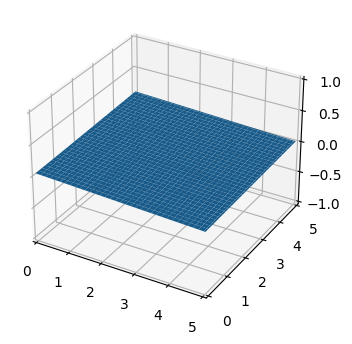

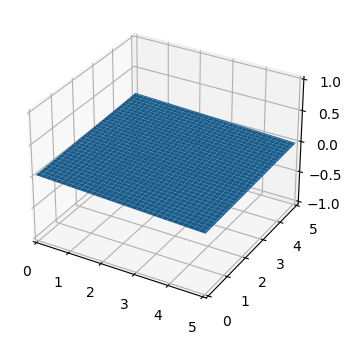

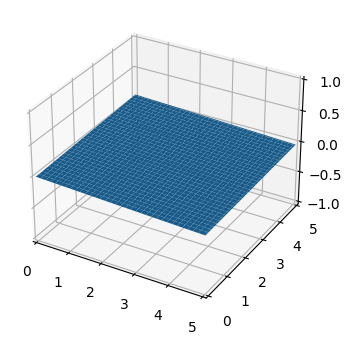

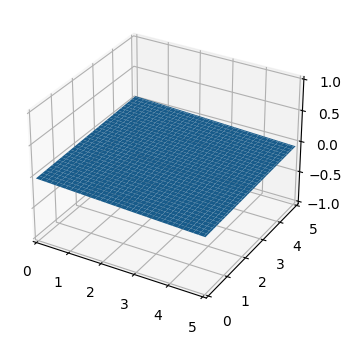

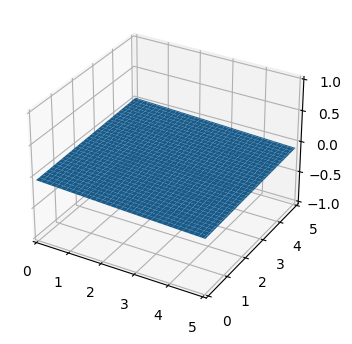

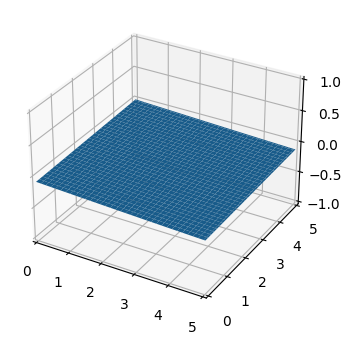

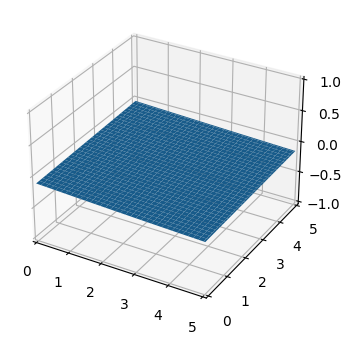

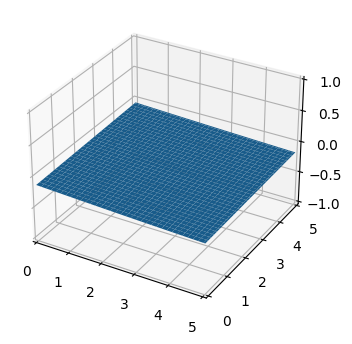

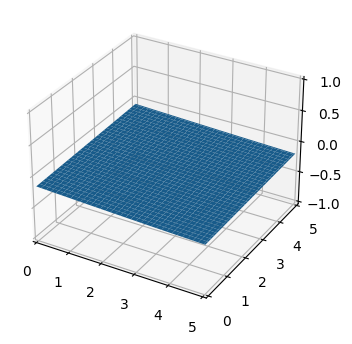

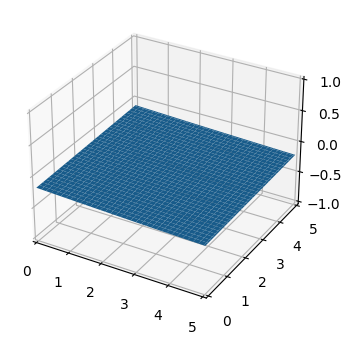

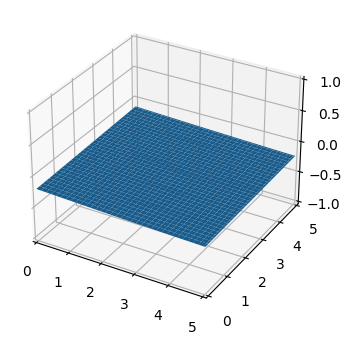

In [ ]:
x, y = np.meshgrid(x_, y_)
for n in range(nt):
        if n % (int(nt / 10)) == 0:
            # t = n * dt   # convert to real time
            n = np.array([n])
            t_inf = np.unique(TX[:,0:1])
            x_inf = np.unique(TX[:,1:2])
            y_inf = np.unique(TX[:,2:3])
            x_inf, y_inf = np.meshgrid(x_inf, y_inf)
            x_inf, y_inf = x_inf.reshape(-1, 1), y_inf.reshape(-1, 1)
            t_inf = np.tile(t_inf.reshape(-1, 1), (1, x_inf.shape[0])).T[:,n]
            u_, gv_ = pinn.infer(t_inf, x_inf, y_inf)

            fig = plt.figure(figsize=(16, 4))
            ax = fig.add_subplot(1, 2, 2, projection = "3d")
            ax.plot_surface(x, y, u_.numpy().reshape(nx, ny), vmin = -1., vmax = 1.)
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin, ymax)
            ax.set_zlim(-1., 1.)

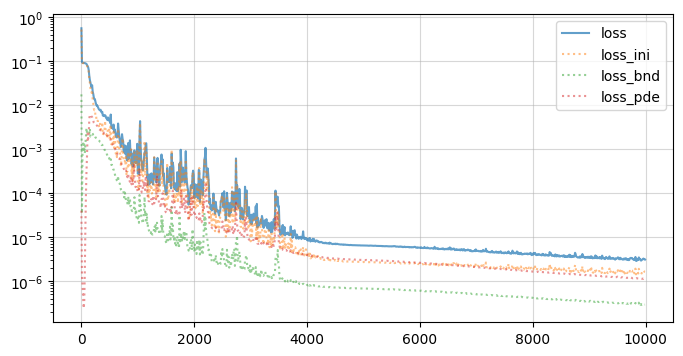

In [ ]:
plt.figure(figsize = (8, 4))
plt.plot(pinn.ep_log, pinn.loss_log,     alpha = .7, linestyle = "-", label = "loss")
plt.plot(pinn.ep_log, pinn.loss_ini_log, alpha = .5, linestyle = ":", label = "loss_ini")
plt.plot(pinn.ep_log, pinn.loss_bnd_log, alpha = .5, linestyle = ":", label = "loss_bnd")
plt.plot(pinn.ep_log, pinn.loss_pde_log, alpha = .5, linestyle = ":", label = "loss_pde")
plt.legend(loc = "upper right")
plt.grid(alpha = .5)
plt.yscale("log")
plt.show()